In [ ]:
!pip3 install --upgrade pandas

In [31]:
import nltk 
nltk.download("wordnet")
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:

from google.colab import drive
drive.mount('/drive', force_remount=True)

%cd "/drive/MyDrive/TextMiningProject/"

Mounted at /drive
/drive/MyDrive/TextMiningProject


In [ ]:
!pip install sklearn
!pip install matplotlib
!pip install import_ipynb
!pip install wandb
!pip install pandas


In [4]:
import sys
import os

py_file_location = "/drive/MyDrive/TextMiningProject/text-preprocessing-techniques"

sys.path.append(os.path.abspath(py_file_location))

In [5]:
import pandas as pd
import random
import seaborn as sn
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import GridSearchCV
#import preprocessor
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier
import import_ipynb
from Utilities import *
from Utilities_2 import *
from preprocess import tokenize 


In [6]:
genuine_sample, bot = generate_data()

In [32]:

train, test = generate_train_test(genuine_sample, bot)


/drive/MyDrive/TextMiningProject/Utilities_2.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssb3_train["Label"] = "bot"
/drive/MyDrive/TextMiningProject/Utilities_2.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genuine_train["Label"] = "genuine"


In [34]:
test

,text,Label
22404,i <ALLCAPS>need a skinny battery 😩 <ALLCAPS>,genuine
34621,<user <ALLCAPS>> w <ALLCAPS>e would really lik...,genuine
15186,mtg <ALLCAPS>got it wrong… <ALLCAPS>she’s th...,genuine
7275,<user <ALLCAPS>> i <ALLCAPS>used to not belie...,genuine
644,Here is a <hashtag <ALLCAPS>> diy <ALLCAPS><a...,bot
...,...,...
20331,<user <ALLCAPS>> e <ALLCAPS>xactly,genuine
29038,<user <ALLCAPS>> <user <ALLCAPS>> <user <ALLCA...,genuine
4656,Are you ready for <hashtag <ALLCAPS>> rhonj to...,genuine
14709,Hi. i’ <ALLCAPS>ll be retweeting the top <numb...,genuine


In [8]:
 report_values(train, test)

,Train,Test
genuine,75197,32228
bot,8771,3759


In [9]:
# Run this cell to downsample
for i in range(2):
  train = downsample_prop(train)
  test = downsample_prop(test)
  



In [10]:
train=downsample(train)
test=downsample(test)

In [11]:
report_values(train, test)

,Train,Test
bot,2168,935
genuine,2168,935


In [12]:
!pip install -q tf-models-official
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

     |████████████████████████████████| 1.8 MB 7.9 MB/s 
     |████████████████████████████████| 1.1 MB 57.0 MB/s 
     |████████████████████████████████| 596 kB 77.7 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 99 kB 12.1 MB/s 
     |████████████████████████████████| 1.2 MB 54.7 MB/s 
     |████████████████████████████████| 90 kB 13.3 MB/s 
     |████████████████████████████████| 4.9 MB 62.5 MB/s 
     |████████████████████████████████| 352 kB 79.9 MB/s 
     |████████████████████████████████| 213 kB 82.1 MB/s 
     |████████████████████████████████| 47.7 MB 66 kB/s 


In [13]:
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

import numpy as np
import sys
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
%matplotlib inline
import seaborn as sns
sns.set()
import wandb
from wandb.keras import WandbCallback

In [14]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__) 
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [15]:
print('Average word length of tweets in dataset is {0:.0f}.'.format(np.mean(train['text'].apply(lambda x: len(x.split())))))
print('Max word length of tweets in dataset is {0:.0f}.'.format(np.max(train['text'].apply(lambda x: len(x.split())))))
print('Average character length of tweets in dataset is {0:.0f}.'.format(np.mean(train['text'].apply(lambda x: len(x)))))


Average word length of tweets in dataset is 20.
Max word length of tweets in dataset is 52.
Average character length of tweets in dataset is 150.


In [16]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',
                            trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy() # checks if the bert layer we are using is uncased or not

tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [17]:
input_string = train.iloc[0]["text"]
print(tokenizer.wordpiece_tokenizer.tokenize(input_string))
print(tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize(input_string)))


['a', '[UNK]', 'mandate', 'has', 'officially', 'been', 'reinstated', 'in', 'p', '[UNK]', 'c', '[UNK]', 'after', 'the', 'b', '[UNK]', 'of', 's', '[UNK]', 'approved', '[UNK]', '[UNK]', '[UNK]']
[1037, 100, 11405, 2038, 3985, 2042, 18671, 1999, 1052, 100, 1039, 100, 2044, 1996, 1038, 100, 1997, 1055, 100, 4844, 100, 100, 100]


In [18]:

# to fit the data

train["Label"].replace({"genuine": 0, "bot": 1}, inplace=True)
test["Label"].replace({"genuine": 0, "bot": 1}, inplace=True)



In [19]:
config = {'label_list' : [0, 1], # Label categories
          'max_seq_length' : 128, # maximum length of (token) input sequences
          'train_batch_size' : 32,
          'learning_rate': 2e-5,
          'epochs':3,
          'optimizer': 'adam',
          'dropout': 0.5,
          'train_samples': len(train),
          'valid_samples': len(test),
          'train_split':0.1,
          'valid_split': 0.01
         }

In [20]:
# This provides a function to convert row to input features and label, 
# this uses the classifier_data_lib which is a class defined in the tensorflow model garden we installed earlier

def create_feature(text, label, label_list=config['label_list'], max_seq_length=config['max_seq_length'], tokenizer=tokenizer):
    """
    converts the datapoint into usable features for BERT using the classifier_data_lib

    Parameters:
    text: Input text string
    label: label associated with the text
    label_list: (list) all possible labels
    max_seq_length: (int) maximum sequence length set for bert
    tokenizer: the tokenizer object instantiated by the files in model assets

    Returns:
    feature.input_ids: The token ids for the input text string
    feature.input_masks: The padding mask generated 
    feature.segment_ids: essentially here a vector of 0s since classification
    feature.label_id: the corresponding label id from lable_list [0, 1] here

    """

    # since we only have 1 sentence for classification purpose, textr_b is None
    example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
    # since only 1 example, the index=0
    feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)

    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [21]:
def create_feature_map(text, label):
    """
    A tensorflow function wrapper to apply the transformation on the dataset.
    Parameters:
    Text: the input text string.
    label: the classification ground truth label associated with the input string

    Returns:
    A tuple of a dictionary and a corresponding label_id with it. The dictionary 
    contains the input_word_ids, input_mask, input_type_ids  
    """

    input_ids, input_mask, segment_ids, label_id = tf.py_function(create_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
    max_seq_length = config['max_seq_length']

    # py_func doesn't set the shape of the returned tensors.
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
    return (x, label_id)

In [22]:
with tf.device('/gpu:0'):
    train = tf.data.Dataset.from_tensor_slices((train['text'].values, train['Label'].values))
    test = tf.data.Dataset.from_tensor_slices((test['text'].values, test['Label'].values))
    # lets look at 3 samples from train set
    for text,label in train.take(3):
        print(text)
        print(label)

# Now we will simply apply the transformation to our train and test datasets

with tf.device('/gpu:0'):
  # train
  train = (train.map(create_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)

                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  test = (test.map(create_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

tf.Tensor(b'a  <ALLCAPS>mask mandate has officially been reinstated in p <ALLCAPS>ima c <ALLCAPS>ounty after the b <ALLCAPS>oard of s <ALLCAPS>upervisors approved reimplementing\xc3\xa2\xc2\x80\xc2\xa6  <ALLCAPS><url <ALLCAPS>>', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'Two storm systems are taking aim at a <ALLCAPS>rizona this week bringing rain,  <ALLCAPS>snow,  <ALLCAPS>strong winds and dropping temperatures.\xc3\xa2\xc2\x80\xc2\xa6  <ALLCAPS><url <ALLCAPS>>', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'$<number <ALLCAPS>> rewards for parents of teen accused in deadly m <ALLCAPS>ichigan school shooting\n<url <ALLCAPS>> <url <ALLCAPS>>', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [23]:
train.element_spec


({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [24]:
from tensorflow.keras import layers

# Building the model, input ---> BERT Layer ---> Classification Head
def create_model():
    
    input_word_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), 
					    dtype=tf.int32,
                                           name="input_word_ids")

    input_mask = tf.keras.layers.Input(shape=(config['max_seq_length'],), 
					dtype=tf.int32,
                                   	name= "input_mask" )
 
    input_type_ids = tf.keras.layers.Input(shape= (config[ 'max_seq_length' ], ) , 
					    dtype=tf.int32,
                                    	    name= "input_type_ids" )
 
 
    pooled_output, sequence_output = bert_layer( [input_word_ids, input_mask, input_type_ids] )
    # for classification we only care about the pooled-output.
    # At this point we can play around with the classification head based on the 
    # downstream tasks and its complexity
 
    drop = tf.keras.layers.Dropout(config[ 'dropout' ] ) (sequence_output)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(drop)
    x = layers.Bidirectional(layers.LSTM(64))(x)

    output = tf.keras.layers.Dense( 1 , activation= 'sigmoid' , name= 'output' ) (x)

    # inputs coming from the function
    model = tf.keras.Model(
      inputs= {
        'input_word_ids' : input_word_ids,
        'input_mask' : input_mask,
        'input_type_ids' : input_type_ids} , 
      outputs=output)
 
    return model

In [25]:
# Calling the create model function to get the keras based functional model
model = create_model()


In [26]:
# using adam with a lr of 2*(10^-5), loss as binary cross entropy as only 
# 2 classes and similarly binary accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.PrecisionAtRecall(0.5),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

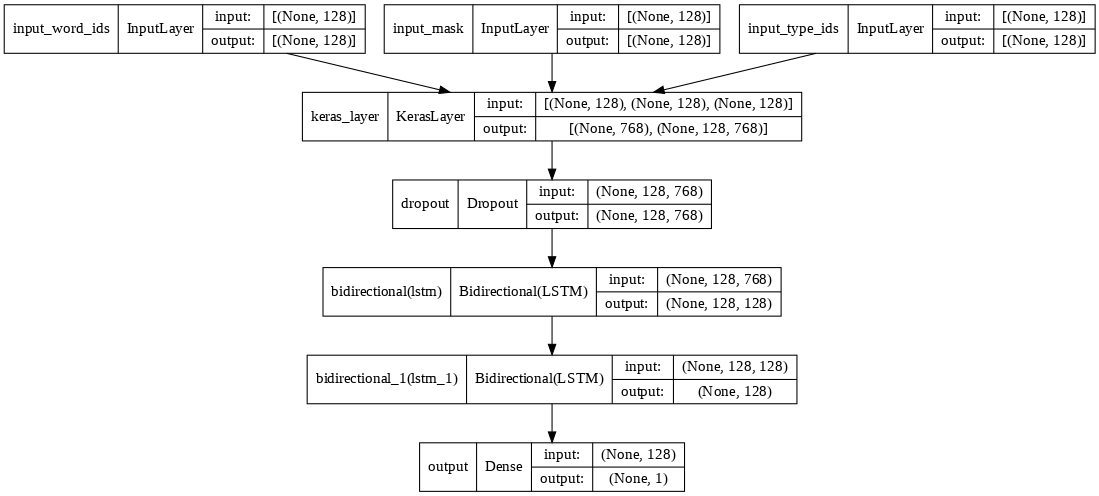

In [27]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76 )


In [28]:
config['model_name'] = 'BERT_BiLSTM_EN_UNCASED_Scraped'

In [30]:
# Train model
# setting low epochs as It starts to overfit with this limited data, please feel free to change
epochs = config['epochs']
history = model.fit(train,
                    validation_data=test,
                    epochs=epochs,
                    verbose=1,
                    )


Epoch 1/3
135/135 [==============================] - 80s 585ms/step - loss: 0.3832 - binary_accuracy: 0.8252 - precision_at_recall: 0.9649 - precision: 0.8582 - recall: 0.7801 - val_loss: 1.0279 - val_binary_accuracy: 0.4962 - val_precision_at_recall: 0.8024 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
135/135 [==============================] - 80s 584ms/step - loss: 0.3681 - binary_accuracy: 0.8250 - precision_at_recall: 0.9603 - precision: 0.8652 - recall: 0.7709 - val_loss: 0.9386 - val_binary_accuracy: 0.4962 - val_precision_at_recall: 0.8066 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
135/135 [==============================] - 80s 585ms/step - loss: 0.3669 - binary_accuracy: 0.8359 - precision_at_recall: 0.9393 - precision: 0.8656 - recall: 0.7965 - val_loss: 1.0351 - val_binary_accuracy: 0.4962 - val_precision_at_recall: 0.8966 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
